In [ ]:
import sys
print(sys.executable)
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn scikit-learn xgboost lightgbm catboost --quiet


/opt/homebrew/opt/python@3.11/bin/python3.11

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


/Users/amual689/Downloads/Examples/MSDS 545/Streamlit/food_access_app_multipleModels/.venv/bin/pip3: line 2: /Users/amual689/Downloads/Examples/MSDS 545/Streamlit/food_access_app_multipleMode/.venv/bin/python: No such file or directory
/Users/amual689/Downloads/Examples/MSDS 545/Streamlit/food_access_app_multipleModels/.venv/bin/pip3: line 2: exec: /Users/amual689/Downloads/Examples/MSDS 545/Streamlit/food_access_app_multipleMode/.venv/bin/python: cannot execute: No such file or directory


# Predictive Modeling of Food Access (3-feature version)  
Dataset: USDA Food Access Research Atlas  
Objective: Use only 3 features to predict “Low Income & Low Access” (LILA) so model & pipeline will expect 3 features.

```python

In [8]:


# 12. In backend you will load these and expect 3 features.


Shape: (72531, 4)
   LILATracts_1And10  HUNVFlag  PovertyRate  LA1and10
0                  0         0         11.3         1
1                  1         0         17.9         1
2                  0         0         15.0         1
3                  0         0          2.8         1
4                  0         1         15.2         1
           HUNVFlag   PovertyRate      LA1and10
count  72531.000000  72528.000000  72531.000000
mean       0.210820     15.183864      0.379810
std        0.407894     11.919903      0.485343
min        0.000000      0.000000      0.000000
25%        0.000000      6.500000      0.000000
50%        0.000000     12.000000      0.000000
75%        0.000000     20.600000      1.000000
max        1.000000    100.000000      1.000000
LILATracts_1And10
0    63238
1     9293
Name: count, dtype: int64


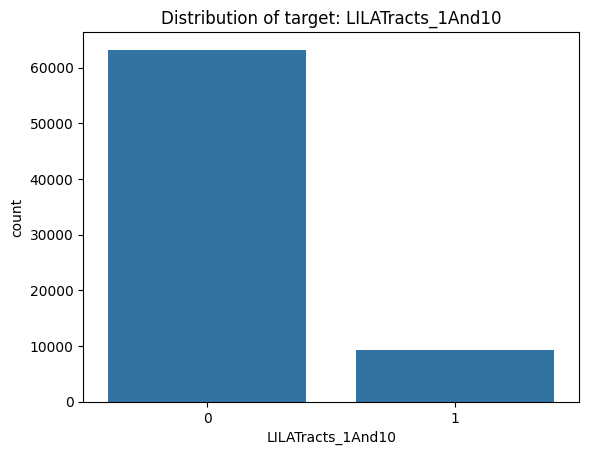

Training shape: (50771, 3) Test shape: (21760, 3)
Accuracy: 0.9159007352941176
Precision: 0.6141019533111005
Recall: 0.9246771879483501
F1-score: 0.7380475236186659
ROC AUC: 0.9809618062834273
Confusion Matrix:
 [[17352  1620]
 [  210  2578]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     18972
           1       0.61      0.92      0.74      2788

    accuracy                           0.92     21760
   macro avg       0.80      0.92      0.84     21760
weighted avg       0.94      0.92      0.92     21760

Saved files: imputer_3features.pkl, scaler_3features.pkl, model_3features.pkl


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import joblib  # for saving model/pipeline

# 1. Load the dataset
df = pd.read_csv("frontend/FoodAccessResearchAtlas.csv", low_memory=False)

# 2. Define target variable
target_col = "LILATracts_1And10"  # or whichever is appropriate in your dataset
df[target_col] = df[target_col].astype(int)

# 3. Select the 3 features you’ll use
feature_cols = [
    'HUNVFlag',    # Flag for low-vehicle access households (vehicle access dimension)
    'PovertyRate', # Percent of population below poverty level (income dimension)
    'LA1and10'     # Low-access flag: 1 mile urban / 10 miles rural (distance dimension)
]

# 4. Subset the DataFrame
df = df[[target_col] + feature_cols].copy()

# 5. Inspect data
print("Shape:", df.shape)
print(df.head())
print(df[feature_cols].describe())
print(df[target_col].value_counts())
sns.countplot(x=target_col, data=df)
plt.title("Distribution of target: " + target_col)
plt.show()

# 6. Handle missing values
imputer = SimpleImputer(strategy='median')
X_raw = imputer.fit_transform(df[feature_cols])
X_raw = pd.DataFrame(X_raw, columns=feature_cols)
y = df[target_col]

# 7. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X = pd.DataFrame(X_scaled, columns=feature_cols)

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("Training shape:", X_train.shape, "Test shape:", X_test.shape)

# 9. Train a logistic regression model (balanced class weight for possible class imbalance)
model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 10. Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 11. Save the preprocessing pipeline and model
joblib.dump(imputer, "imputer_3features.pkl")
joblib.dump(scaler, "scaler_3features.pkl")
joblib.dump(model, "model_3features.pkl")
print("Saved files: imputer_3features.pkl, scaler_3features.pkl, model_3features.pkl")


In [9]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# 1. Load your data (with your 3 selected features and target)
df = pd.read_csv("FoodAccessResearchAtlas.csv", low_memory=False)
target_col = "LILATracts_1And10"
feature_cols = ['HUNVFlag', 'PovertyRate', 'LA1and10']
df = df[[target_col] + feature_cols].dropna().copy()
X_raw = df[feature_cols]
y = df[target_col].astype(int)

# 2. Impute & Scale
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X_raw)
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",   # or "auc"
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# 5. Evaluate
y_pred  = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6. Save preprocessing + model
joblib.dump(imputer, "imputer_xgb.pkl")
joblib.dump(scaler, "scaler_xgb.pkl")
joblib.dump(xgb_clf, "model_xgb.pkl")
print("Saved XGBoost model and pipeline: imputer_xgb.pkl, scaler_xgb.pkl, model_xgb.pkl")


ModuleNotFoundError: No module named 'xgboost'

In [14]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

# 1. Load your data (with your 3 selected features and target)
df = pd.read_csv("FoodAccessResearchAtlas.csv", low_memory=False)
target_col = "LILATracts_1And10"
feature_cols = ['HUNVFlag', 'PovertyRate', 'LA1and10']
df = df[[target_col] + feature_cols].dropna().copy()
X_raw = df[feature_cols]
y = df[target_col].astype(int)

# 2. Impute & Scale
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X_raw)
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Train Logistic Regression model
logreg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# 5. Evaluate
y_pred  = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6. Save preprocessing + model
joblib.dump(imputer, "imputer_logistic.pkl")
joblib.dump(scaler, "scaler_logistic.pkl")
joblib.dump(logreg, "model_logistic.pkl")
print("Saved Logistic Regression model and pipeline: imputer_logistic.pkl, scaler_logistic.pkl, model_logistic.pkl")


Accuracy: 0.9175513580587343
Precision: 0.6191846522781774
Recall: 0.9261119081779053
F1-score: 0.7421672894509916
ROC AUC: 0.9812505960354652
Confusion Matrix:
 [[17383  1588]
 [  206  2582]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     18971
           1       0.62      0.93      0.74      2788

    accuracy                           0.92     21759
   macro avg       0.80      0.92      0.85     21759
weighted avg       0.94      0.92      0.92     21759

Saved Logistic Regression model and pipeline: imputer_logistic.pkl, scaler_logistic.pkl, model_logistic.pkl


In [16]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

# 1. Load your data (with your 3 selected features and target)
df = pd.read_csv("FoodAccessResearchAtlas.csv", low_memory=False)
target_col  = "LILATracts_1And10"
feature_cols = ['HUNVFlag', 'PovertyRate', 'LA1and10']
df = df[[target_col] + feature_cols].dropna().copy()
X_raw = df[feature_cols]
y     = df[target_col].astype(int)

# 2. Impute & Scale
imputer = SimpleImputer(strategy='median')
X_imp   = imputer.fit_transform(X_raw)
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 4. Train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# 5. Evaluate
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:",     accuracy_score(y_test, y_pred))
print("Precision:",    precision_score(y_test, y_pred))
print("Recall:",       recall_score(y_test, y_pred))
print("F1-score:",     f1_score(y_test, y_pred))
print("ROC AUC:",      roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6. Save preprocessing + model
joblib.dump(imputer,    "imputer_rf.pkl")
joblib.dump(scaler,     "scaler_rf.pkl")
joblib.dump(rf,         "model_rf.pkl")
print("Saved Random Forest model and pipeline: imputer_rf.pkl, scaler_rf.pkl, model_rf.pkl")


Accuracy: 0.9088652971184338
Precision: 0.5925925925925926
Recall: 0.9239598278335724
F1-score: 0.7220742817098809
ROC AUC: 0.9776918058197565
Confusion Matrix:
 [[17200  1771]
 [  212  2576]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     18971
           1       0.59      0.92      0.72      2788

    accuracy                           0.91     21759
   macro avg       0.79      0.92      0.83     21759
weighted avg       0.94      0.91      0.92     21759

Saved Random Forest model and pipeline: imputer_rf.pkl, scaler_rf.pkl, model_rf.pkl
